In [1]:
!pip install tensorflow opencv-python matplotlib pandas scikit-learn

In [2]:
import os
from pathlib import Path

In [3]:
import tensorflow as tf
import cv2 as cv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
def plot_history(history):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    print(history.history.keys())
    epoch = range(len(loss))

    ax1.plot(epoch, loss, label="Training Loss")
    ax1.plot(epoch, val_loss, label="Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(epoch, accuracy, label="Training Accuracy")
    ax2.plot(epoch, val_accuracy, label="Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

In [5]:
data_dir = Path(os.getcwd()) / ".dataset"
train_direcory = data_dir / "Training"
test_direcory = data_dir / "Testing"

In [7]:
_seed = 9118487
validation_split = .2

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_direcory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    validation_split=validation_split,
    subset='training',
    seed=_seed
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_direcory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    validation_split=validation_split,
    subset='validation',
    seed=_seed
)

test_dateset = tf.keras.utils.image_dataset_from_directory(
    test_direcory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    seed=_seed
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
for images, labels in train_dataset.take(1):
    img = images[0].numpy().astype("uint8")
    # label = labels[0].numpy()
    label = labels[0]
    input_data_shape = np.array(img).shape

label: 3
shape: (256, 256, 3)
image:


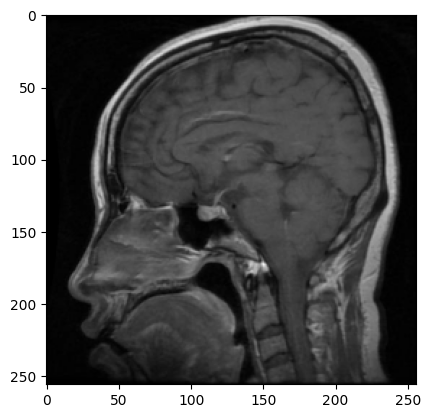

In [10]:
print(f"label: {label}")
print(f"shape: {np.array(img).shape}")
print("image:")
plt.imshow(img)
plt.show()

# Model MLP

In [11]:
mlp_model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=input_data_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(train_dataset.class_names), activation='softmax')
    ]
)

mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
mlp_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

mlp_history = mlp_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[mlp_early_stopping]
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.3313 - loss: 3664.2209 - val_accuracy: 0.2648 - val_loss: 1.7025
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.3003 - loss: 1.5692 - val_accuracy: 0.2648 - val_loss: 1.3626
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3089 - loss: 1.5418 - val_accuracy: 0.2648 - val_loss: 1.3546
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.3037 - loss: 1.3465 - val_accuracy: 0.2648 - val_loss: 1.3508
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3046 - loss: 1.3439 - val_accuracy: 0.2648 - val_loss: 1.3489
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.3063 - loss: 1.3480 - val_accuracy: 0.2648 - val_loss: 1.3477
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.2932 - loss: 1.3511 - val_accuracy: 0.2648 - val_loss: 1.3475
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.2968 - loss: 1.3500 - val_accuracy: 0.264

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


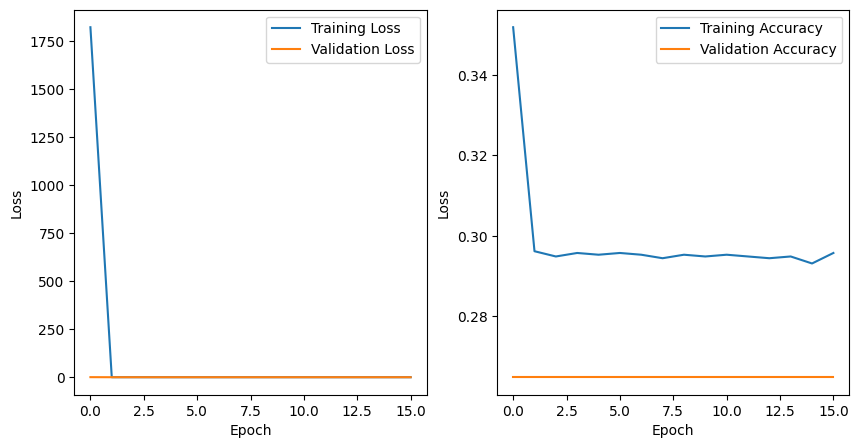

In [14]:
plot_history(mlp_history)

In [15]:
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(test_dateset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.3002 - loss: 6.2066


In [16]:
print(f"test accuracy: {mlp_test_acc:.4f}")

test accuracy: 0.2665


In [17]:
cnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1./255, input_shape=input_data_shape),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(.3),
        tf.keras.layers.Dense(len(train_dataset.class_names), activation='softmax')
    ]
)

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
cnn_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

cnn_history = cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[cnn_early_stopping]
    )

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 209ms/step - accuracy: 0.4343 - loss: 1.4588 - val_accuracy: 0.6794 - val_loss: 0.7548
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.7055 - loss: 0.7256 - val_accuracy: 0.7840 - val_loss: 0.5358
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.8053 - loss: 0.4910 - val_accuracy: 0.8449 - val_loss: 0.3561
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8646 - loss: 0.3426 - val_accuracy: 0.8693 - val_loss: 0.3173
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9097 - loss: 0.2249 - val_accuracy: 0.8641 - val_loss: 0.3683
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9285 - loss: 0.1771 - val_accuracy: 0.8937 - val_loss: 0.3617


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


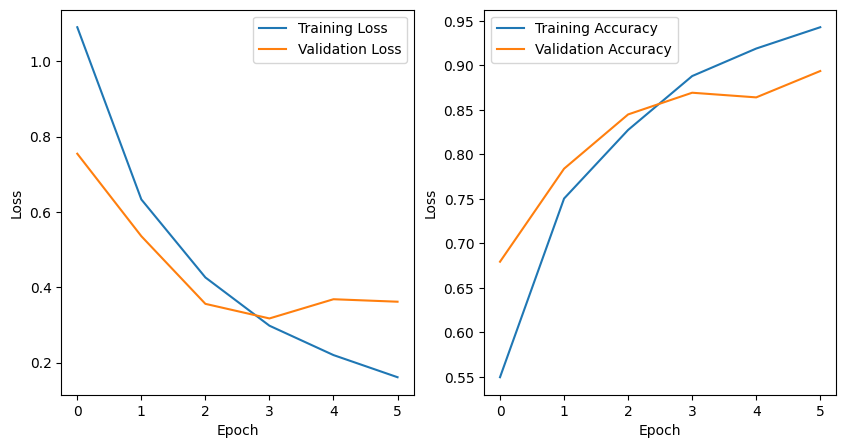

In [19]:
plot_history(cnn_history)

In [20]:
cnn_model_loss, cnn_model_acc = cnn_model.evaluate(test_dateset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.5787 - loss: 2.7523


In [21]:
print(f"test accuracy: {cnn_model_acc:.4f}")

test accuracy: 0.5685


# Automatyczne strojenie MLP z KerasTuner i EarlyStopping
W tej sekcji znajdziemy najlepszą architekturę MLP korzystając z KerasTuner oraz callbacku EarlyStopping.

In [23]:
# Install KerasTuner if not already installed
try:
    import keras_tuner as kt
except ImportError:
    !pip install keras-tuner --quiet
    import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [24]:
def build_mlp_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_data_shape))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ))
        if hp.Boolean('use_dropout'):
            model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(len(train_dataset.class_names), activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [25]:
tuner = kt.RandomSearch(
    build_mlp_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='mlp_tuner_dir',
    project_name='mlp_tuning'
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stop]
)

best_hps = tuner.get_best_hyperparameters(1)[0]
print('Najlepsze hiperparametry:')
for k, v in best_hps.values.items():
    print(f'{k}: {v}')

Trial 10 Complete [00h 00m 43s]
val_accuracy: 0.7404181361198425

Best val_accuracy So Far: 0.7491289377212524
Total elapsed time: 00h 09m 11s
Najlepsze hiperparametry:
num_layers: 3
units_0: 224
activation: relu
use_dropout: False
learning_rate: 0.000976698895553929
units_1: 160
units_2: 96


In [26]:
# Trenowanie i ocena najlepszego modelu MLP
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stop]
)

mlp_tuned_test_loss, mlp_tuned_test_acc = best_model.evaluate(test_dateset)
print(f"Tuned MLP test accuracy: {mlp_tuned_test_acc:.4f}")

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3469 - loss: 4271.5532 - val_accuracy: 0.4756 - val_loss: 445.6483
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5404 - loss: 304.0155 - val_accuracy: 0.6341 - val_loss: 123.5579
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6312 - loss: 146.9249 - val_accuracy: 0.6934 - val_loss: 157.4315
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6430 - loss: 154.9612 - val_accuracy: 0.5662 - val_loss: 161.0068
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6518 - loss: 118.6674 - val_accuracy: 0.6446 - val_loss: 97.6429
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.7082 - loss: 93.5101 - val_accuracy: 0.6899 - val_loss: 68.8904
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7365 - loss: 51.7925 - val_accuracy: 0.5889 - val_loss: 84.9167
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7771 - loss: 31.2656 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


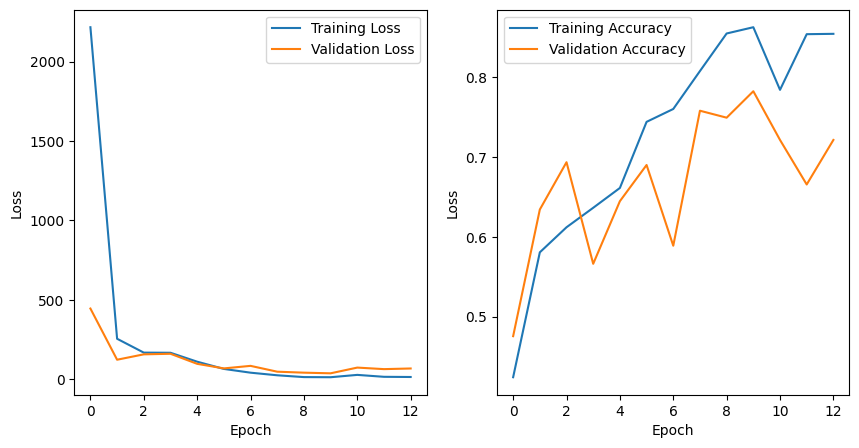

In [27]:
plot_history(history)

In [30]:
tuned_mlp_loss, tuned_mlp_accuracy = best_model.evaluate(test_dateset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6191 - loss: 357.0357


In [31]:
print(f"Tuned MLP test accuracy: {tuned_mlp_accuracy:.4f}")

Tuned MLP test accuracy: 0.6168


In [32]:
best_model.summary(

)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 224)            │    44,040,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 160)            │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 96)             │        15,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,276,782 (504.60 MB)

 Trainable params: 44,092,260 (168.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,184,522 (336.40 MB)

# Tuned CNN Model

In [36]:
from warnings import filters
def build_cnn_model(hp, layers=5):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_data_shape))
  for layers_number in range(hp.Int('number_of_layers', 1, layers)):
    model.add(
        tf.keras.layers.Conv2D(
            filters=hp.Int(f'filters_{layers_number}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{layers_number}', [3, 5]),
            activation='relu'
        )
    )
    model.add(
        tf.keras.layers.MaxPooling2D()
    )
  model.add(
      tf.keras.layers.Flatten()
  )
  for layers_number in range(hp.Int('number_of_dense_layers', 0, layers)):
    model.add(
        tf.keras.layers.Dense(
            units=hp.Int(f'units_{layers_number}', min_value=32, max_value=256, step=32),
            activation='relu'
        )
    )
    if hp.Boolean('use_dropout'):
      model.add(
          tf.keras.layers.Dropout(hp.Float(f'dropout_{layers_number}', 0.1, 0.5, step=0.1))
      )
  model.add(
      tf.keras.layers.Dense(len(train_dataset.class_names), activation='softmax')
  )
  optimizer = tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
  )
  model.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [ ]:
cnn_tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_tuner_dir',
    project_name='cnn_tuning'
)

tuned_cnn_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


cnn_tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[tuned_cnn_early_stopping]
)

Trial 1 Complete [00h 02m 34s]
val_accuracy: 0.8466898798942566

Best val_accuracy So Far: 0.8466898798942566
Total elapsed time: 00h 02m 34s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
3                 |4                 |number_of_layers
64                |64                |filters_0
3                 |3                 |kernel_size_0
2                 |0                 |number_of_dense_layers
0.00011358        |0.00011523        |learning_rate
128               |32                |filters_1
5                 |3                 |kernel_size_1
96                |32                |filters_2
5                 |3                 |kernel_size_2
128               |32                |filters_3
5                 |3                 |kernel_size_3

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4164 - loss: 1.2587